In [3]:
%matplotlib inline
import scipy
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns

In [4]:
print(f'scipy: {scipy.__version__}')
print(f'numpy: {np.__version__}')

scipy: 1.2.1
numpy: 1.16.2


## Gamma Distribution

Text(0.5, 0, 'x')

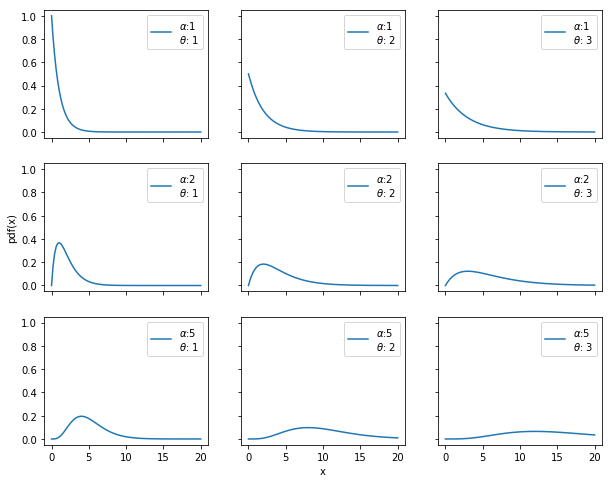

In [10]:
rates = [1,2,5]
scales = [1,2,3]

x = np.linspace(0,20,100)
fig, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True, figsize=(10,8))

for i, r in enumerate(rates):
    for j, s in enumerate(scales):
        rv = stats.gamma(a=r, scale=s)
        ax[i,j].plot(x, rv.pdf(x), label=f'$\\alpha$:{r}\n$\\theta$: {s}')
        ax[i,j].legend()

ax[1,0].set_ylabel('pdf(x)')
ax[2,1].set_xlabel('x')

In [2]:
np.repeat(5,10)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

## Binomial Distribution

In [13]:
n, p = 5, 0.4

mean, var, skew, kurt = stats.binom.stats(n,p, moments='mvsk')
mean, var, skew, kurt

(array(2.), array(1.2), array(0.18257419), array(-0.36666667))

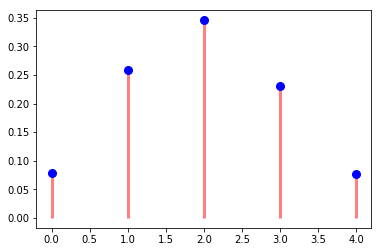

In [26]:
x = np.arange(stats.binom.ppf(0.01,n,p),stats.binom.ppf(0.99,n,p))

plt.plot(x, stats.binom.pmf(x,n,p), 'bo', ms=8)
plt.vlines(x,0, stats.binom.pmf(x,n,p), 'r', lw=3, alpha=0.5)

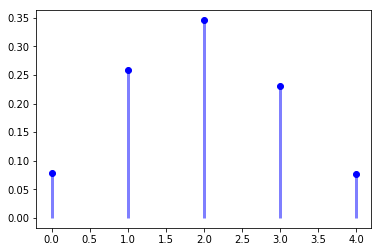

In [25]:
dist = stats.binom(n,p)
plt.plot(x, dist.pmf(x), 'bo')
plt.vlines(x,0, dist.pmf(x), 'b', lw=3, alpha=0.5)

## pymc3 intro

In [4]:
np.random.seed(123)
n_trials = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real, size=n_trials)
data

array([1, 0, 0, 0])

##### beta distribution is flat for a=1, b=1 (flat prior)

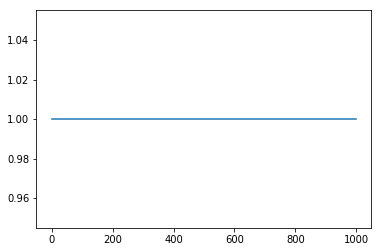

In [17]:
dist = stats.beta(a=1,b=1)
pdf = dist.pdf(x=np.linspace(dist.ppf(0.01), dist.ppf(0.99), 1000))
plt.plot(pdf)

In [38]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start, chains=1)

logp = -2.7726, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 1553.83it/s]
Sequential sampling (1 chains in 1 job)
Metropolis: [theta]
100%|██████████| 1500/1500 [00:00<00:00, 4952.44it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7e3d6e4e0>,
      dtype=object)

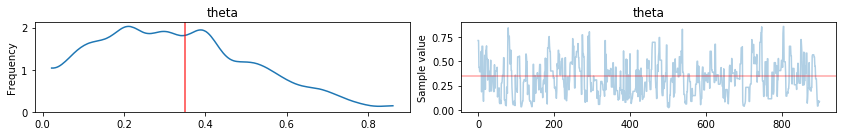

In [39]:
burnin = 100 # throw awaay starting samples
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta': theta_real})

In [40]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step, start=start, chains=4)

/home/majeed/leraning/env3.6/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2.7726, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 1747.51it/s]
Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 6727.16draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7e6fe1128>,
      dtype=object)

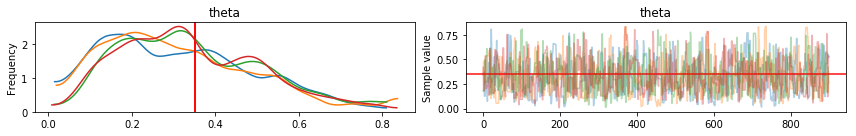

In [41]:
chains = multi_trace[burnin:]
pm.traceplot(chains, lines={'theta': theta_real})

In [42]:
# gelman rubin test for convergese ~1. Applicable for >1 chains
pm.gelman_rubin(chains)

{'theta': 1.0036470481164645}

In [43]:
pm.summary(chains)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.327669,0.173564,0.005711,0.027517,0.648877,821.311158,1.003647


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe81f217be0>]],
      dtype=object)

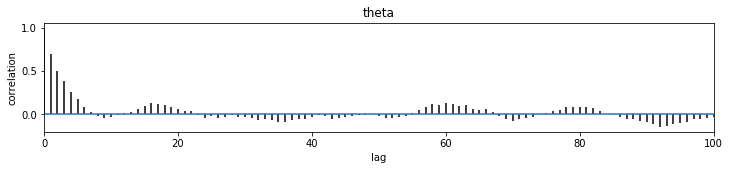

In [45]:
# samples shouldn't autocorrelate. They should be inndependent of each other ~0
pm.autocorrplot(chain)

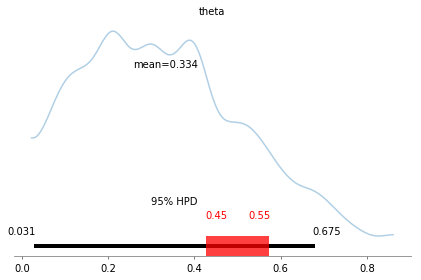

In [46]:
pm.plot_posterior(chain, kde_plot=True, rope=[0.45,0.55])

## Gaussian

In [5]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

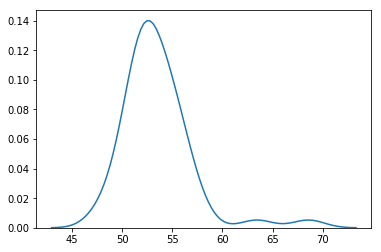

In [6]:
sns.kdeplot(data)

In [7]:
with pm.Model() as gauss_model:
    mu = pm.Uniform('mu', 40,75)
    sd = pm.HalfNormal('sigma', sd=10)
    y = pm.Normal('y', mu=mu, sd=sd, observed=data)
    
    traceg = pm.sample(1100, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, mu]
100%|██████████| 1600/1600 [00:02<00:00, 765.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0aadab7278>,
      dtype=object)

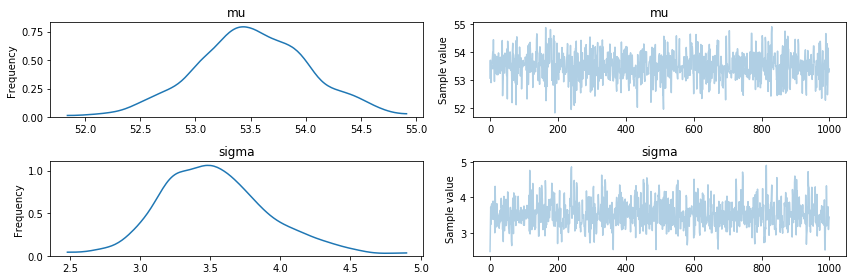

In [9]:
chain_g = traceg[100:]
pm.traceplot(chain_g)

In [10]:
pm.summary(chain_g)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,53.502485,0.512290,0.016482,52.482184,54.490815
sigma,3.534314,0.387227,0.012071,2.853013,4.351790


#### inference using posterior

In [11]:
y_preds = pm.sampling.sample_posterior_predictive(trace=chain_g,samples=100,model=gauss_model, size=len(data)) 

100%|██████████| 100/100 [00:00<00:00, 420.22it/s]


In [12]:
pm.sampling.sample_posterior_predictive?

In [18]:
y_preds['y'][0].mean(axis=0).shape

(48,)

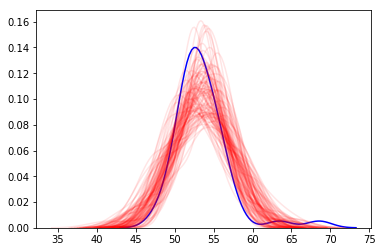

In [21]:
sns.kdeplot(data, color='b')
for y_pred in y_preds['y']:
    sns.kdeplot(y_pred[0], color='r', alpha=0.1)

In [73]:
sampled_g_chain['y'].shape

(100, 48, 48)

In [72]:
len(data)

48

In [74]:
gauss_model.observed_RVs

[y]